<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20Using%20Data%20Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [58]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  Fi

In [59]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [60]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [61]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [62]:
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Augmented.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'negative').sum())


1208


In [63]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

1671
     Sentiment                                           Sentence
2     negative  The international electronic industry company ...
415   negative  A tinyurl link takes users to a scamming site ...
421   negative  Compared with the FTSE 100 index , which rose ...
423   negative  Compared with the FTSE 100 index , which rose ...
500   negative  One of the challenges in the oil production in...
...        ...                                                ...
5445  negative  The cargo handling group posted a surprise dro...
5446  negative  The share prices in London ended lower on Mond...
5447  negative  The operating profit fell from the previous ye...
5448  negative  Net sales of the Paper segment decreased to 22...
5449  negative  In January, sales in Finland decreased by 10% ...

[1208 rows x 2 columns]


In [64]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [65]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4775,2,"The apartment block will be well-located , in ..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...
4787,2,Our superior customer centricity and expertise...


<Axes: xlabel='count', ylabel='Sentiment'>

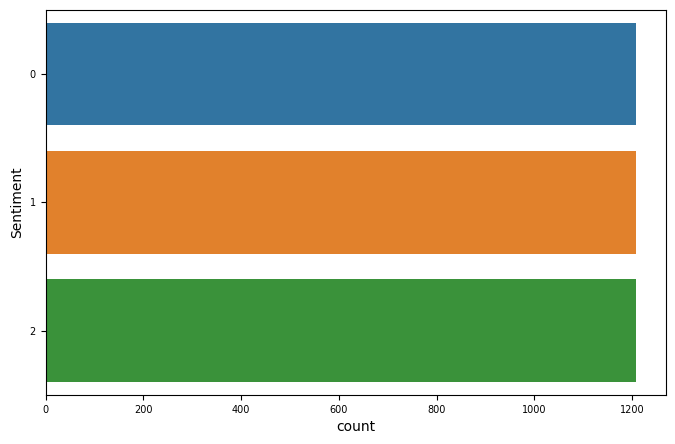

In [66]:
sns.countplot(y="Sentiment",data=df)

In [67]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4775,2,"The apartment block will be well-located , in ..."
4780,2,"The antibody , given at repeated doses of up t..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...
4787,2,Our superior customer centricity and expertise...


### Sentiment Analysis using BERT

In [68]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [69]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .',
       'Compared with the FTSE 100 index , which rose 36.7 points ( or 0.6 % ) on the day , this was a relative price change of -0.2 % .',
       'Compared with the FTSE 100 index , which rose 94.9 points ( or 1.6 % ) on the day , this was a relative price change of -0.4 % .',
       ...,
       'The apartment block will be well-located , in easy reach of the city center and close to both a school and kindergarten .',
       'The antibody , given at repeated doses of up to 8 mg-kg , was generally well tolerated , and the pharmacokinetic characteristics of BTT-1023 in psoriasis patients were consistent with those observed in a previously completed study in rheumatoid arthritis RA patients .',
       'Our superior customer centricity and expertise in digital services set us apart from our competitors .'],
      dtype=object)

In [71]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')

In [72]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [73]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [74]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [75]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 8

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [76]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [77]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [78]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [79]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [55]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/Augmented_BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)

    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/8 [01:29<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 1/8 [01:35<11:11, 96.00s/it]

Accuracy:238/253
 -> 0.9407114624505929
Accuracy:178/238
 -> 0.7478991596638656
Accuracy:200/232
 -> 0.8620689655172413
Validation loss: 0.6090223655759633
F1 Score (weighted): 0.850556371857658
Accuracy Score: 0.8520055325034578



 12%|█▎        | 1/8 [03:02<11:11, 96.00s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 2/8 [03:09<09:26, 94.36s/it]

Accuracy:243/253
 -> 0.9604743083003953
Accuracy:194/238
 -> 0.8151260504201681
Accuracy:185/232
 -> 0.7974137931034483
Validation loss: 0.7025385501264891
F1 Score (weighted): 0.858864092118705
Accuracy Score: 0.8603042876901799



 25%|██▌       | 2/8 [04:35<09:26, 94.36s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 3/8 [04:41<07:47, 93.57s/it]

Accuracy:241/253
 -> 0.9525691699604744
Accuracy:182/238
 -> 0.7647058823529411
Accuracy:200/232
 -> 0.8620689655172413
Validation loss: 0.7484455319303139
F1 Score (weighted): 0.8602458737290444
Accuracy Score: 0.8616874135546335



 38%|███▊      | 3/8 [06:07<07:47, 93.57s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 4/8 [06:14<06:12, 93.05s/it]

Accuracy:242/253
 -> 0.9565217391304348
Accuracy:184/238
 -> 0.773109243697479
Accuracy:197/232
 -> 0.8491379310344828
Validation loss: 0.7762664061264841
F1 Score (weighted): 0.8602060484599663
Accuracy Score: 0.8616874135546335



 50%|█████     | 4/8 [07:39<06:12, 93.05s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 5/8 [07:46<04:38, 92.76s/it]

Accuracy:240/253
 -> 0.9486166007905138
Accuracy:184/238
 -> 0.773109243697479
Accuracy:201/232
 -> 0.8663793103448276
Validation loss: 0.7823768080593404
F1 Score (weighted): 0.8632120964852231
Accuracy Score: 0.8644536652835408



 62%|██████▎   | 5/8 [09:12<04:38, 92.76s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 6/8 [09:19<03:05, 92.75s/it]

Accuracy:241/253
 -> 0.9525691699604744
Accuracy:185/238
 -> 0.7773109243697479
Accuracy:200/232
 -> 0.8620689655172413
Validation loss: 0.7841680666708751
F1 Score (weighted): 0.8645401367976435
Accuracy Score: 0.8658367911479945



 75%|███████▌  | 6/8 [10:44<03:05, 92.75s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 7/8 [10:51<01:32, 92.62s/it]

Accuracy:241/253
 -> 0.9525691699604744
Accuracy:185/238
 -> 0.7773109243697479
Accuracy:200/232
 -> 0.8620689655172413
Validation loss: 0.7841663163486013
F1 Score (weighted): 0.8645401367976435
Accuracy Score: 0.8658367911479945



 88%|████████▊ | 7/8 [12:17<01:32, 92.62s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 8/8 [12:23<00:00, 92.98s/it]

Accuracy:241/253
 -> 0.9525691699604744
Accuracy:185/238
 -> 0.7773109243697479
Accuracy:200/232
 -> 0.8620689655172413
Validation loss: 0.7934379740790873
F1 Score (weighted): 0.8645401367976435
Accuracy Score: 0.8658367911479945


In [56]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 91/91 [00:06<00:00, 13.90it/s]


In [57]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:241/253
 -> 0.9525691699604744
Accuracy:185/238
 -> 0.7773109243697479
Accuracy:200/232
 -> 0.8620689655172413


0.8658367911479945